In [3]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.utils import resample

In [6]:
df = pd.read_csv("Amazon Customer Reviews.csv")

In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
df = df.drop(["Id", "ProductId", "UserId", "ProfileName", "Time"], axis=1)

In [9]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   HelpfulnessNumerator    568454 non-null  int64 
 1   HelpfulnessDenominator  568454 non-null  int64 
 2   Score                   568454 non-null  int64 
 3   Summary                 568427 non-null  object
 4   Text                    568454 non-null  object
dtypes: int64(3), object(2)
memory usage: 21.7+ MB


In [11]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,568454.000000,568454.00000,568454.000000
mean,1.743817,2.22881,4.183199
std,7.636513,8.28974,1.310436
min,0.000000,0.00000,1.000000
25%,0.000000,0.00000,4.000000
50%,0.000000,1.00000,5.000000
75%,2.000000,2.00000,5.000000
max,866.000000,923.00000,5.000000


In [12]:
df = df[(df["HelpfulnessNumerator"] >= 0) &
        (df["HelpfulnessDenominator"] >= 0)]
df["helpfulness_ratio"] = df["HelpfulnessNumerator"] / \
    df["HelpfulnessDenominator"]

In [13]:
df.sample()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,helpfulness_ratio
141660,0,0,3,Not impressed.,"For me, nobody can beat Dunkin Donuts coffee. ...",NaN


In [14]:
def helpfulness_ratio_enc(df):
    if df["helpfulness_ratio"] >= 0.0 and df["helpfulness_ratio"] < 0.2:
        return 1
    elif df["helpfulness_ratio"] >= 0.2 and df["helpfulness_ratio"] < 0.4:
        return 2
    elif df["helpfulness_ratio"] >= 0.4 and df["helpfulness_ratio"] < 0.6:
        return 3
    elif df["helpfulness_ratio"] >= 0.6 and df["helpfulness_ratio"] < 0.8:
        return 4
    elif df["helpfulness_ratio"] >= 0.8 and df["helpfulness_ratio"] <= 1.0:
        return 5
    elif (df["HelpfulnessNumerator"]) == 0 and (df["HelpfulnessDenominator"]) == 0:
        return df['Score']

In [15]:
df["helpfulness_ratio_enc"] = df.apply(helpfulness_ratio_enc, axis=1)

In [16]:
df.drop(["HelpfulnessNumerator", "HelpfulnessDenominator",
        "helpfulness_ratio"], axis=1, inplace=True)

In [17]:
df.sample()

,Score,Summary,Text,helpfulness_ratio_enc
235355,3,A little stale...but I'll give them another ch...,I searched out my favorite KIND bars on Amazon...,3.0


In [18]:
df["helpfulness_ratio_enc"].dropna(inplace=True, axis=0)

In [19]:
df

,Score,Summary,Text,helpfulness_ratio_enc
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,5.0
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,5.0
3,2,Cough Medicine,If you are looking for the secret ingredient i...,5.0
4,5,Great taffy,Great taffy at a great price. There was a wid...,5.0
...,...,...,...,...
568449,5,Will not do without,Great for sesame chicken..this is a good if no...,5.0
568450,2,disappointed,I'm disappointed with the flavor. The chocolat...,2.0
568451,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",5.0
568452,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,5.0


In [20]:
def clean_text(text):
    text = str(text)

    # remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # remove html
    text = re.sub(r"<.*?>", "", text)

    # remove emojis and non-letters
    text = re.sub(r"[\U00010000-\U0010ffff]", "", text)

    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [21]:
df_test = df.copy()

In [22]:
df_test["Summary"] = df_test["Summary"].apply(clean_text)
df_test["Text"] = df_test["Text"].apply(clean_text)

In [23]:
df_test

,Score,Summary,Text,helpfulness_ratio_enc
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,5.0
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,4,Delight says it all,This is a confection that has been around a fe...,5.0
3,2,Cough Medicine,If you are looking for the secret ingredient i...,5.0
4,5,Great taffy,Great taffy at a great price There was a wide ...,5.0
...,...,...,...,...
568449,5,Will not do without,Great for sesame chickenthis is a good if not ...,5.0
568450,2,disappointed,Im disappointed with the flavor The chocolate ...,2.0
568451,5,Perfect for our maltipoo,These stars are small so you can give 1015 of ...,5.0
568452,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,5.0


<Axes: xlabel='Score', ylabel='count'>

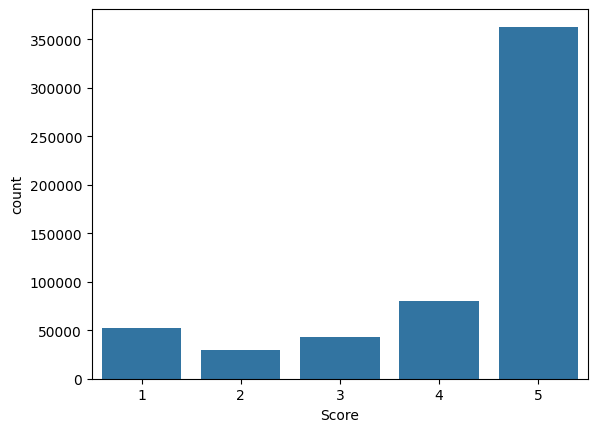

In [24]:
sns.countplot(data=df_test, x="Score")

<Axes: xlabel='helpfulness_ratio_enc', ylabel='count'>

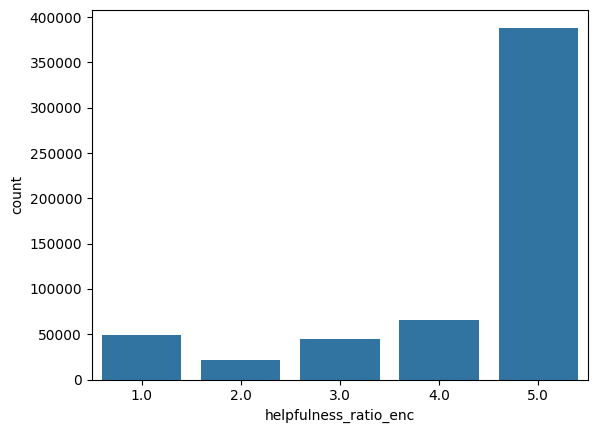

In [25]:
sns.countplot(data=df_test, x="helpfulness_ratio_enc")

In [26]:
score5 = df_test[df_test["Score"] == 5]
rest = df_test[df_test["Score"] != 5]

In [27]:
score5_downsampled = resample(
    score5,
    replace=False,
    n_samples=75000,
    random_state=42,
)

In [28]:
df_balanced = pd.concat([rest, score5_downsampled])

df_balanced = df_balanced.sample(
    frac=1, random_state=42).reset_index(drop=True)

In [29]:
df_balanced

,Score,Summary,Text,helpfulness_ratio_enc
0,1,Disgusting Curry,I thought that Ship Madras Curry was going to ...,1.0
1,5,Great for nutrition,I used to buy this at the store but since I st...,5.0
2,4,Switch to Switch,I guess everybodys making a carbonated fruit d...,1.0
3,5,Great for the money,I find pepper blends to have more flavor for u...,5.0
4,4,Great for on the run meal,Great for on the run meal Tuna is not my favor...,5.0
...,...,...,...,...
280327,4,Great Product Shipping cost is high,I really like these caps They have allowed me ...,4.0
280328,5,Great Treat,This product is great for your pets teeth and ...,5.0
280329,4,Cat likes it more than I do,I bought this to test the various varieties on...,5.0
280330,4,vegan mac cheese,We love this easy tasty vegan mac cheese If yo...,5.0


<Axes: xlabel='Score', ylabel='count'>

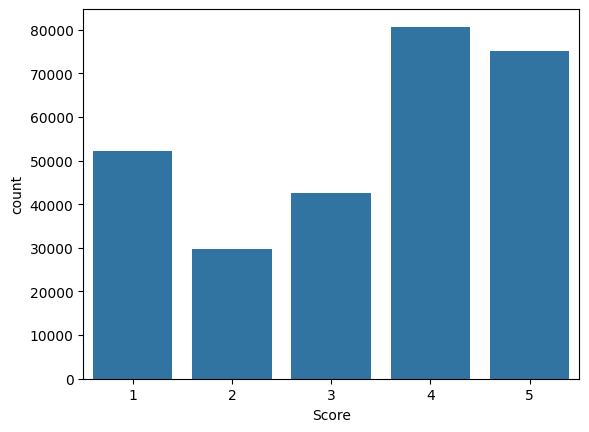

In [30]:
sns.countplot(data=df_balanced, x="Score")

In [31]:
###########################################################################

In [32]:
df_balanced["full_text"] = df_balanced["Summary"].astype(
    str) + " " + df_balanced["Text"].astype(str)

In [33]:
df_balanced["label"] = df_balanced["Score"].astype(int)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["full_text"], df_balanced["label"], test_size=0.2, random_state=42, stratify=df_balanced["label"]
)

In [35]:
tfidf = TfidfVectorizer(max_features=70000, ngram_range=(1, 2), min_df=3)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [36]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)

In [37]:
class_weights_dict = {cls: w for cls, w in zip(classes, class_weights)}
class_weights_dict

{1: 1.0726790070311378,
 2: 1.8833928196514802,
 3: 1.314874530956848,
 4: 0.6951366933234145,
 5: 0.74755}

In [38]:
clf = LogisticRegression(
    class_weight=class_weights_dict, max_iter=5000, n_jobs=-1)

clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight={1: 1.0726790070311378, 2: 1.8833928196514802,
                                 3: 1.314874530956848, 4: 0.6951366933234145,
                                 5: 0.74755},
                   max_iter=5000, n_jobs=-1)

In [39]:
y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.79      0.79     10454
           2       0.53      0.61      0.57      5954
           3       0.59      0.64      0.61      8528
           4       0.72      0.64      0.68     16131
           5       0.76      0.78      0.77     15000

    accuracy                           0.70     56067
   macro avg       0.68      0.69      0.68     56067
weighted avg       0.70      0.70      0.70     56067

[[ 8258  1454   449   140   153]
 [ 1109  3604   932   207   102]
 [  537  1155  5423  1145   268]
 [  331   424  1987 10307  3082]
 [  227   163   368  2561 11681]]


In [40]:
def predict_review(text):
    clean = clean_text(text)
    vec = tfidf.transform([clean])
    pred = clf.predict(vec)[0]

    labels = {
        1: "Very negative",
        2: "Negative",
        3: "Neutral",
        4: "Positive",
        5: "Very positive"
    }

    return labels.get(pred, "Unknown sentiment")

In [41]:
text = "I used to buy this at the store but since I started drinking it a couple times a day buying by the case makes more sense"
prediction = predict_review(text)
prediction

'Very positive'

In [42]:
text = "I guess everybodys making a carbonated fruit drink these days Pepsi is going in for it in a big way I prefer a glassbottled drink but I did like Switchs tangy clean taste No big gummy sugary mess but a nice balanced blend This one watermelon strawberry was cool I appreciate a vitaminc kickgotta stay healthy and there is no sugarso where did the 140 calories come from The can says 100 juice and thats what I came for"
prediction = predict_review(text)
prediction

'Positive'

In [43]:
text = "This is only okay I prefer other pod coffees but I usually buy coffee beans and grind my own coffee and use the CoffeeDuck the Refillable Filter Senseo Pod Coffee Machines with my Senseo Its a lot cheaper But if you like the froth on top of your coffee the CoffeeDuck doesnt give you any And the cleanup is a little messier"
prediction = predict_review(text)
prediction

'Neutral'

In [44]:
print(df_balanced[df_balanced["Summary"] ==
      "Switch to Switch"]["Text"].iloc[0])

I guess everybodys making a carbonated fruit drink these days Pepsi is going in for it in a big way I prefer a glassbottled drink but I did like Switchs tangy clean taste No big gummy sugary mess but a nice balanced blend This one watermelon strawberry was cool I appreciate a vitaminc kickgotta stay healthy and there is no sugarso where did the 140 calories come from The can says 100 juice and thats what I came for


In [45]:
print(
    df_balanced[
        df_balanced["Score"] == 3
    ]["Text"].iloc[0]
)

This is only okay I prefer other pod coffees but I usually buy coffee beans and grind my own coffee and use the CoffeeDuck the Refillable Filter Senseo Pod Coffee Machines with my Senseo Its a lot cheaper But if you like the froth on top of your coffee the CoffeeDuck doesnt give you any And the cleanup is a little messier


In [46]:
df_balanced

,Score,Summary,Text,helpfulness_ratio_enc,full_text,label
0,1,Disgusting Curry,I thought that Ship Madras Curry was going to ...,1.0,Disgusting Curry I thought that Ship Madras Cu...,1
1,5,Great for nutrition,I used to buy this at the store but since I st...,5.0,Great for nutrition I used to buy this at the ...,5
2,4,Switch to Switch,I guess everybodys making a carbonated fruit d...,1.0,Switch to Switch I guess everybodys making a c...,4
3,5,Great for the money,I find pepper blends to have more flavor for u...,5.0,Great for the money I find pepper blends to ha...,5
4,4,Great for on the run meal,Great for on the run meal Tuna is not my favor...,5.0,Great for on the run meal Great for on the run...,4
...,...,...,...,...,...,...
280327,4,Great Product Shipping cost is high,I really like these caps They have allowed me ...,4.0,Great Product Shipping cost is high I really l...,4
280328,5,Great Treat,This product is great for your pets teeth and ...,5.0,Great Treat This product is great for your pet...,5
280329,4,Cat likes it more than I do,I bought this to test the various varieties on...,5.0,Cat likes it more than I do I bought this to t...,4
280330,4,vegan mac cheese,We love this easy tasty vegan mac cheese If yo...,5.0,vegan mac cheese We love this easy tasty vegan...,4


In [47]:
df_balanced.to_csv("Amazon Customer Reviews Cleaned Balanced.csv", index=False)

In [48]:
df_balanced

,Score,Summary,Text,helpfulness_ratio_enc,full_text,label
0,1,Disgusting Curry,I thought that Ship Madras Curry was going to ...,1.0,Disgusting Curry I thought that Ship Madras Cu...,1
1,5,Great for nutrition,I used to buy this at the store but since I st...,5.0,Great for nutrition I used to buy this at the ...,5
2,4,Switch to Switch,I guess everybodys making a carbonated fruit d...,1.0,Switch to Switch I guess everybodys making a c...,4
3,5,Great for the money,I find pepper blends to have more flavor for u...,5.0,Great for the money I find pepper blends to ha...,5
4,4,Great for on the run meal,Great for on the run meal Tuna is not my favor...,5.0,Great for on the run meal Great for on the run...,4
...,...,...,...,...,...,...
280327,4,Great Product Shipping cost is high,I really like these caps They have allowed me ...,4.0,Great Product Shipping cost is high I really l...,4
280328,5,Great Treat,This product is great for your pets teeth and ...,5.0,Great Treat This product is great for your pet...,5
280329,4,Cat likes it more than I do,I bought this to test the various varieties on...,5.0,Cat likes it more than I do I bought this to t...,4
280330,4,vegan mac cheese,We love this easy tasty vegan mac cheese If yo...,5.0,vegan mac cheese We love this easy tasty vegan...,4
